# (Transform part) ETL: Cómo obtener todos los datos de todos los restaurantes en Rappi

En síntesis, este notebook es el primero de 3 que explican cómo obtener en .csv:
<ol>
<li>Los países disponibles en Rappi: paises_rappi.csv</li>
<li>Los cadenas de restaurantes disponibles en cada país: cadenas_restaurantes_df.csv</li>
<li>Las sucursales de cada cadena junto con sus atributos.</li>
<li>Una tabla aparte listando las opiniones ligadas a cada sucursal: opiniones_sucursales.csv</li>
</ol>
------
<p>Nota: Este código no tiene multiprocessing ni scrapping. A lo mucho te dolerá entender las expresiones regulares jaja.</p>
<p>Fecha de edición: 6/12/2022</p>


Importamos las librerías a utilizar durante todo el proyecto:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import re
from IPython.display import clear_output

## Revisamos nulos
Como esta parte del ETL se trata de transformar y tampoco quiero perder los datos brutos que obtuvimos, nombraremos nuestro main df como "atributos_sucursales_df" para dejar intacto los datos de "atributos_sucursales_bruto.csv".

In [2]:
atributos_sucursales_df = pd.read_csv("atributos_sucursales_bruto.csv")

Las listas por defecto se interpretan como strings a la hora de leerlas, por esta razón y porque vamos a continuamente exportar y leer este df, creé una función que interpreta correctamente nuestros datos.

In [3]:
def clean_alt_list(list_): # Gracias Max Hilsdorf por ayudarme con este código 
    list_ = list_.replace('nan', '"nan"')
    return list_

def interpretar_bien_df(dataframe):
    # Evaluamos las listas de estas columnas para que Pandas no las interprete como strings
    if "opinions" in dataframe.columns:
        dataframe["opinions"] = dataframe["opinions"].apply(eval)
    if "prices" in dataframe.columns:
        dataframe["prices"] = dataframe["prices"].apply(eval)
    if "attributes" in dataframe.columns:
        # Attributes es un caso especial, necesitamos aplicarle 2 funciones
        dataframe["attributes"] = dataframe["attributes"].apply(clean_alt_list)
        dataframe["attributes"] = dataframe["attributes"].apply(eval)
    # Chequeamos como quedó el resultado
    return dataframe

In [4]:
# Le aplicamos la función
atributos_sucursales_df = interpretar_bien_df(atributos_sucursales_df)
# Veamos como queda
atributos_sucursales_df.head(3)

,id_sucursal,attributes,prices,opinions
0,0,"[4.2, 450, 20 - 35 min, Gratis(nuevos usuarios)]","[$ 520,00, $ 400,00, $ 400,00, $ 400,00, $ 650...","[(Calidad de la comida, 27%), (Justo lo que pe..."
1,1,"[nan, nan, nan, Gratis(nuevos usuarios)]","[$ 177,00, $ 231,00, $ 177,00, $ 398,00, $ 362...",[]
2,2,"[nan, nan, 23 - 38 min, Gratis(nuevos usuarios)]","[$ 1.210,00, $ 350,00, $ 510,00, $ 585,00, $ 5...",[]


Chequeamos si se produjo un error en alguna de las columnas. Esto identificando que si hubiera un error, estaría como tipo str en vez de list

In [5]:
for column in atributos_sucursales_df.columns:
    df_con_errores = atributos_sucursales_df[atributos_sucursales_df[column].apply(lambda x:
                                                                                   isinstance(x, str))]
    if len(df_con_errores) == 0:
        print(f"En la columna '{column}' NO hubo errores")
    else:
        print(f"En la columna '{column}' SÍ hubo errores")

En la columna 'id_sucursal' NO hubo errores
En la columna 'attributes' NO hubo errores
En la columna 'prices' NO hubo errores
En la columna 'opinions' NO hubo errores


Ahora debemos de reemplazar las listas vacías por NaNs para poder visualizar mejor estos datos

In [6]:
for column in atributos_sucursales_df.columns:
    atributos_sucursales_df[column] = atributos_sucursales_df[column].apply(
                                        lambda x: np.nan if x == []
                                                else x)
# Veamos como quedó
atributos_sucursales_df.sample(3)

,id_sucursal,attributes,prices,opinions
29590,29590,"[4.5, 355, 35 - 50 min, Gratis(nuevos usuarios)]","[$ 14.900, $ 77.900, $ 25.400, $ 18.900, $ 10....","[(Justo lo que pedí, 25%), (Calidad de la comi..."
25791,25791,"[nan, nan, 35 - 50 min, Gratis(nuevos usuarios)]","[$ 17.400, $ 11.000, $ 14.000, $ 47.800, $ 30....",NaN
10760,10760,"[nan, nan, 35 - 50 min, Gratis(nuevos usuarios)]","[$ 222.00, $ 318.00, $ 191.00, $ 124.00, $ 126...",NaN


Veamos los valores nulos en nuestro dataset

<AxesSubplot: >

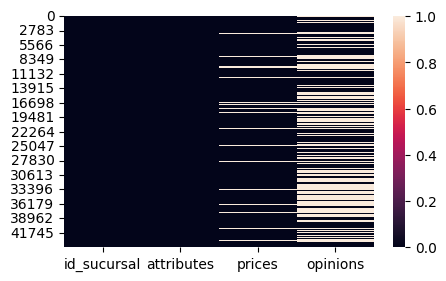

In [7]:
plt.figure(figsize=(5,3))
sns.heatmap(atributos_sucursales_df.isnull())

Podemos notar 2 cosas:
<ol>
 <li>Algunos datos en *precios* son nulos. Esto se puede deber a:
  <ul>  - Las sucursales no han publicado su catálogo de productos.</ul>
   <ul> - O se han desabilitados algunos catálogos de algunas sucursales.</ul></li>
 <li>Opiniones tiene un montón de nulos. Este caso ya se debe a que:
   <ul> - Las sucursales no tiene opiniones aún. (Esto podría deberse a que son nuevas).</ul>
    <ul>- Las sucursales ya tienen opiniones pero Rappi no displaya cómo estan compuestas en específico. (Ni idea de porqué haría esto, podría ser que consideran número insuficiente de opiniones para sacar el recuadro).</ul></li>
  </ol>  
<p>Bien, reemplazemos estos nulos de acuerdo al caso:</p>

In [8]:
# Para opiniones 2 cosas:
# 1. Crearé una nueva columna con valores booleanos para usarlo como filtro después.
atributos_sucursales_df["mostraba_opiniones"] = atributos_sucursales_df["opinions"].apply(
                                        lambda x: True if type(x) is list
                                                else False)
# 2. Reemplazaré todas las opiniones vacías por una tupla que las represente
atributos_sucursales_df["opinions"] = atributos_sucursales_df["opinions"].apply(
                                        lambda x: x if type(x) is list
                                                else [("Sin opiniones", "100%")])

In [9]:
# Para prices solo reemplazaremos estas listas vacías por una mejor representación
atributos_sucursales_df["prices"] = atributos_sucursales_df["prices"].apply(
                                        lambda x: x if isinstance(x, list)
                                                else [0])

<AxesSubplot: >

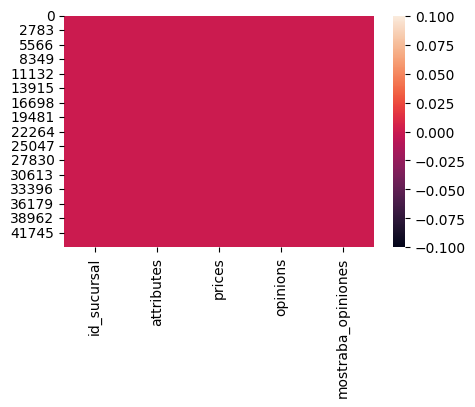

In [10]:
# Chequeamos por última vez
plt.figure(figsize=(5,3))
sns.heatmap(atributos_sucursales_df.isnull())

In [11]:
# Guardamos una copia de seguridad como checkpoint
df_checkpoint_1 = atributos_sucursales_df.copy()

## La última batalla. Parseando atributos y normalizando opiniones

Esta es la parte donde más craneo debes meter si no estás acostumbrado a crear tablas relacionales desde Python. Pero tranquilo, respira, y di conmigo: "Amaré a Python aunque aparezcan 1000 excepciones".
Este es el plan:
1) A la columna atributos la separaremos en 4 columnas: overral_stars, number_opinions, delivery_time, tipo_de_envio.
2) A la columna prices la reduciremos a overall_price_usd. Para esto deberemos convertir cada moneda de cada país a doláres.
3) A la columna opinions la normalizaremos en 3 tablas: pivot_tb, text_opinion_tb y percent_tb.
---
Esta más decir que limpiaremos y reemplazaremos muchos NaNs en el camino. Así que: "THIS IS PYTHON"

### 1. Parseando attributes

In [12]:
# Creamos las columnas en base al índice de los attributes
nuevas_columnas = ["overral_stars", "number_opinions", "tiempo_delivery", "tipo_envio"]

# Creamos las nuevas columnas en nuestro df
for i, column in enumerate(nuevas_columnas):
    atributos_sucursales_df[column] = atributos_sucursales_df["attributes"].apply(
                                                                                lambda x: x[i]
                                                                                )
# Eliminamos la vieja columna
atributos_sucursales_df.drop(["attributes"], axis=1, inplace=True)

In [13]:
# Ahora reemplazamos los NaNs por valores con más sentido para cada caso
valores_reemplazo_nans = [0.0, # Como en Rappi la mínima calificación es 1. Es intuitivo decir que 0 significa sin opinión 
                          0, # Sin opiniones o 0 opiniones
                         '0', # Sin tiempo de delivery. En string para mantener la columna en un solo tipo de dato
                         "No específicado"]
# Realizamos el reemplazo
for i, column in enumerate(nuevas_columnas):
    atributos_sucursales_df[column] = atributos_sucursales_df[column].replace(
                                                                                {'nan': valores_reemplazo_nans[i]}
                                                                                )

Como Rappi también trabaja con Brazil, para las columnas que sean naturalmente texto (*opinions* y *tipo_envio*) tendremos que reemplazar cada frase en portugués por su contraparte en español. Empecemos con la segunda.

In [14]:
# Chequeamos que valores tiene esta columna
atributos_sucursales_df["tipo_envio"].unique()

array(['Gratis(nuevos usuarios)', 'No específicado',
       'Grátis(novos usuários)'], dtype=object)

In [15]:
# Reemplazamos los valores en portugués por español
atributos_sucursales_df["tipo_envio"] = atributos_sucursales_df["tipo_envio"].apply(lambda x:
                                                                                'Gratis (nuevos usuarios)'
                                                                                   if (x == "Grátis(novos usuários)" or  x == "Gratis(nuevos usuarios)")
                                                                                   else x)

In [16]:
# Chequamos
atributos_sucursales_df["tipo_envio"].unique()

array(['Gratis (nuevos usuarios)', 'No específicado'], dtype=object)

Cool, todo bien, continuemos.

In [17]:
# Veamos como va quedando
atributos_sucursales_df.head(2)

,id_sucursal,prices,opinions,mostraba_opiniones,overral_stars,number_opinions,tiempo_delivery,tipo_envio
0,0,"[$ 520,00, $ 400,00, $ 400,00, $ 400,00, $ 650...","[(Calidad de la comida, 27%), (Justo lo que pe...",True,4.2,450,20 - 35 min,Gratis (nuevos usuarios)
1,1,"[$ 177,00, $ 231,00, $ 177,00, $ 398,00, $ 362...","[(Sin opiniones, 100%)]",False,0.0,0,0,Gratis (nuevos usuarios)


In [18]:
# Ordenamos el df
atributos_sucursales_df = atributos_sucursales_df.sort_values("id_sucursal")
# Guardamos nuestro avance
df_checkpoint_2 = atributos_sucursales_df.copy()

### Parseando tiempo_delivery
Este parseo es sencillo, solo vamos a sacar el mínimo y máximo de los rangos de tiempo de delivery por cada sucursal.

Para las sucursales que dan un número fijo en lugar de un rango de tiempo vamos a usar este número tanto como máximo y como mínimo, de esta manera no se pierde información entre las distintas sucursales.

In [19]:
# Dividir en 2 mínimo y máximo el rango de tiempo de delivery.
atributos_sucursales_df['min_tiempo_delivery'] = 0
atributos_sucursales_df['max_tiempo_delivery'] = 0

for index, value in atributos_sucursales_df["tiempo_delivery"].iteritems():
    if ' - ' in value:
        # Split on ' - ' and extract the numbers
        min_time, max_time = value.split(' - ')
        atributos_sucursales_df.at[index, 'min_tiempo_delivery'] = int(min_time.split()[0])
        atributos_sucursales_df.at[index, 'max_tiempo_delivery'] = int(max_time.split()[0])
    else:
        # Extract single value and assign it to both columns
        delivery_time = int(value.split()[0])
        atributos_sucursales_df.at[index, 'min_tiempo_delivery'] = delivery_time
        atributos_sucursales_df.at[index, 'max_tiempo_delivery'] = delivery_time

C:\Users\augus\AppData\Local\Temp\ipykernel_9672\3056415513.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in atributos_sucursales_df["tiempo_delivery"].iteritems():


In [20]:
# Now we can get rid off 'tiempo_delivery' column
atributos_sucursales_df.drop(columns=['tiempo_delivery'], inplace=True)

# Let's take a look!
atributos_sucursales_df.sample(3)

,id_sucursal,prices,opinions,mostraba_opiniones,overral_stars,number_opinions,tipo_envio,min_tiempo_delivery,max_tiempo_delivery
12118,12118,"[$ 52.66, $ 79.00, $ 315.00, $ 398.00, $ 349.0...","[(Tal como lo pedí, 25%), (Calidad de la comid...",True,4.6,83,Gratis (nuevos usuarios),35,50
31838,31838,"[$ 15.000, $ 11.000, $ 9.990, $ 15.000, $ 22.0...","[(Sin opiniones, 100%)]",False,0.0,0,Gratis (nuevos usuarios),0,0
8721,8721,"[$ 174.30, $ 418.00, $ 199.00, $ 399.00, $ 99....","[(Justo lo que pedí, 17%), (Pésima calidad, 11...",True,4.1,46,Gratis (nuevos usuarios),35,50


In [22]:
# Guardamos nuestro avance
df_checkpoint_3 = atributos_sucursales_df.copy()

### 2. Normalizando prices

Cada país tiene una manera única de representar centavos. En Perú los centavos son después del punto, en México es después la coma. Otras diferencias se pueden notar en los demás países, pero, para efectos prácticos, vamos representar las monedas como un float en Python (los centavos después del punto).

Para esta solución se usa un regex que:
1) Analiza el caso de cada moneda.
2) Saque su conversión a doláres.
3) Clasifique las monedas en 2 grupos (El grupo 1 (donde los céntimos son los primeros digitos de izquierda a derecha separados un '.' o una ',') y el grupo 2 (donde no existen los céntimos).
4) Creé una expresión regular que, en base a sus grupos, parsea las monedas como flotantes de Python.
-----
Para comenzar a separar las monedas en grupos, obtengamos los id_pais de cada row.

In [49]:
# Importamos los dfs
cadenas_restaurantes_df = pd.read_csv("cadenas_restaurantes.csv") 
sucursales_df = pd.read_csv("sucursales_bruto.csv")
# Realizamos un join y nos quedamos con el id del país y de la sucursal
df_merged = sucursales_df.merge(cadenas_restaurantes_df, on="id_cadena", how='inner')
# Hacemos un merge de este último df con el atributos para conseguir el id_pais aquí
atributos_sucursales_df = atributos_sucursales_df.merge(df_merged, on ="id_sucursal", how='inner')

# Let's take a look
atributos_sucursales_df.head(3)

,id_sucursal,prices,opinions,mostraba_opiniones,overral_stars,number_opinions,tipo_envio,min_tiempo_delivery,max_tiempo_delivery,id_cadena,url_sucursal,nombre_sucursal,direccion_sucursal,nombre_cadena,url_cadena,id_pais
0,0,"[$ 520,00, $ 400,00, $ 400,00, $ 400,00, $ 650...","[(Calidad de la comida, 27%), (Justo lo que pe...",True,4.2,450,Gratis (nuevos usuarios),20,35,0,https://www.rappi.com.uy/restaurantes/113198-z...,Zoubar,8 de Octubre 2698,Zoubar,https://www.rappi.com.uy/restaurantes/delivery...,8
1,1,"[$ 177,00, $ 231,00, $ 177,00, $ 398,00, $ 362...","[(Sin opiniones, 100%)]",False,0.0,0,Gratis (nuevos usuarios),0,0,1,https://www.rappi.com.uy/restaurantes/120305-y...,Yuppy Burger,"Colonia 1779, Montevideo, Departamento de Mont...",Yuppy Burger,https://www.rappi.com.uy/restaurantes/delivery...,8
2,2,"[$ 1.210,00, $ 350,00, $ 510,00, $ 585,00, $ 5...","[(Sin opiniones, 100%)]",False,0.0,0,Gratis (nuevos usuarios),23,38,2,https://www.rappi.com.uy/restaurantes/119128-w...,Wok in Box - Williman,"Claudio Williman 626, 11300 Montevideo, Depart...",Wok in Box,https://www.rappi.com.uy/restaurantes/delivery...,8


Bien. Todo perfecto, ahora sí veamos esas expresiones regulares.

In [50]:
def currency_parser(currency_string: str, id_pais: int) -> float:
    # To show what each step does, we are gonna start with 4 examples: '₡ 17.990,00', '$ 108.00', 'S/ 28.60', 'R$ 49,99'
    # Be sure this is a valid string
    if (currency_string == 0) or (currency_string == '0') or (currency_string == ''):
        return 0.0
    
    # Get rid off any unuseful characters
    string_without_special_chars = re.sub('[$]|[R]|[₡]|[S/]|[\s]', '', currency_string) # In our examples: '17.990,00', '49,99', '108.00', '28.60'

    if id_pais in (6 ,7): # México o Perú. In our examples would be: '108.00', '28.60'
        string_parsed = string_without_special_chars.replace(',', '')
        
    else: # In our examples would be: '17.990,00', '49,99'
        string_parsed = string_without_special_chars.replace('.', '')
        string_parsed = string_parsed.replace(',', '.')
    
    return float(string_parsed)

def parse_prices(row):
    return [currency_parser(price, row['id_pais']) for price in row['prices']]

# Apply the function to each value in the lists
atributos_sucursales_df['prices'] = atributos_sucursales_df.apply(parse_prices, axis=1)

# Now that don't need 'id_pais', we can get rid off some columns that are already included in other csv's
atributos_sucursales_df.drop(columns=['nombre_cadena', 'url_cadena', 'id_pais'], inplace=True)

# Let's take a look
atributos_sucursales_df.head(3)

,id_sucursal,prices,opinions,mostraba_opiniones,overral_stars,number_opinions,tipo_envio,min_tiempo_delivery,max_tiempo_delivery,id_cadena,url_sucursal,nombre_sucursal,direccion_sucursal
0,0,"[520.0, 400.0, 400.0, 400.0, 650.0, 495.0, 630...","[(Calidad de la comida, 27%), (Justo lo que pe...",True,4.2,450,Gratis (nuevos usuarios),20,35,0,https://www.rappi.com.uy/restaurantes/113198-z...,Zoubar,8 de Octubre 2698
1,1,"[177.0, 231.0, 177.0, 398.0, 362.0, 467.0, 572...","[(Sin opiniones, 100%)]",False,0.0,0,Gratis (nuevos usuarios),0,0,1,https://www.rappi.com.uy/restaurantes/120305-y...,Yuppy Burger,"Colonia 1779, Montevideo, Departamento de Mont..."
2,2,"[1210.0, 350.0, 510.0, 585.0, 585.0, 630.0, 63...","[(Sin opiniones, 100%)]",False,0.0,0,Gratis (nuevos usuarios),23,38,2,https://www.rappi.com.uy/restaurantes/119128-w...,Wok in Box - Williman,"Claudio Williman 626, 11300 Montevideo, Depart..."


In [51]:
# We are gonna use those prices and normalize them into a another table. This will help Power BI load faster our data
prices_per_sucursal_df = atributos_sucursales_df[['id_sucursal', 'prices']].copy()

# Use explode to expand lists in 'prices' column into separate rows
df_exploded = prices_per_sucursal_df.explode('prices', ignore_index=True)

# Now we use aggregate the information to reduce the number of rows
df_counts = df_exploded.groupby(['id_sucursal', 'prices']).size().reset_index(name='num_products')

# Let's take a look
df_counts.head(10)

,id_sucursal,prices,num_products
0,0,84.0,1
1,0,85.0,1
2,0,90.0,1
3,0,140.0,2
4,0,145.0,3
5,0,150.0,1
6,0,165.0,1
7,0,175.0,3
8,0,180.0,1
9,0,200.0,6


In [52]:
# Now that we saved the information, can get rid off column 'prices'
atributos_sucursales_df.drop(columns=['prices'], inplace=True)

# Let's save it into a .csv
df_counts.to_csv('prices_per_sucursal.csv', index=False)

# Guardamos nuestro avance
df_checkpoint_4 = atributos_sucursales_df.copy()

### 3. Normalizando opinions

Todo este proyecto ha demorado tiempo. Y va a llevar más. (para que engañarnos xD). Ahora toca estandarizar la columna opiniones, pasar todo lo que está en portugués a español y crearle una tabla propia para evitar hacer más pesado el archivo.

Con este propósito, dividimos el df en los países de habla hispana y Brazil, cada uno con su propio df.

In [53]:
opinions_per_sucursal_df = atributos_sucursales_df[['id_sucursal', 'opinions']].copy()

# Use explode to expand lists in 'opinions' column into separate rows
df_exploded = opinions_per_sucursal_df.explode('opinions', ignore_index=True)

# Convert 'opinions' column into separate columns by expanding each tuple
df_exploded[['opinion', 'value']] = pd.DataFrame(df_exploded['opinions'].tolist(), index=df_exploded.index)

# Convert percentage strings to decimals
df_exploded['value'] = df_exploded['value'].str.replace('%', '').astype(float) / 100

# Drop the original 'opinions' column if it's no longer needed
df_exploded.drop(columns=['opinions'], inplace=True)

# Let's take a look!
df_exploded.head(5)

,id_sucursal,opinion,value
0,0,Calidad de la comida,0.27
1,0,Justo lo que pedí,0.14
2,0,Tal como lo pedí,0.12
3,0,Pésima calidad,0.06
4,0,Mala calidad,0.06


In [4]:
# Ahora a cambiar las opiniones en portugués a español, de ese modo en reporte estará en 1 solo idioma.
portugues_a_español ={
    'Sin opiniones': 'Sin opiniones',
    'Qualidade da comida': 'Calidad de la comida',
    'Outras razões': 'Otras razones',
    'Melhorar experiência': 'Mejorar la experiencia',
    'Experiência complicada':'Experiencia complicada',
    'Faltou alguns produtos': 'Faltaron algunos productos',
    'Melhorar comunicação': 'Mejorar la comunicación',
    'Não veio o que eu pedi': 'No fue lo que pedí',
    'Exatamente como eu pedi':'Exacto lo que pedi',
    'Qualidade dos ingredientes': 'La calidad de los ingredientes',
    'Ótima comunicação':'Excelente comunicación',
    'Colocar todos os ingred.': 'Incluir todos los items',
    'Ótima experiência': 'Gran experiencia',
    'Comida ruim/má qualidade': 'Pobre calidad',
    'Tempo ideal/pontual': 'Muy puntual',
    'Atendimento ruim': 'Mal trato',
    'Melhorar tempo de preparo': 'Podría ser más rápido',
    'Apresentação do prato': 'La presentacion',
    'Ótima embalagem': 'Buena presentación',
    'Melhorar embalagem': 'Mejorar la presentación',
    'Preparado tarde demais': 'Demora excesiva',
    'Embalagem ruim/vazamento': 'Mala presentación',
    'Ótimo atendimento': 'La atención', # Yo supongo que esto es positivo
    'Ótima qualidade': 'La calidad', # Yo supongo que esto es positivo
    'Qualidade mediana': "Calidad mediana", # Esta yo la creé
    'Realizar modificações': "Realizar cambios", # Esta yo la creé
    'Responder modificações': "Realizar cambios", # Esta yo la creé
    'Melhorar ingredientes': "Mejorar ingredientes", # Esta yo la creé
    'Entregador não responde': 'Delivery no respondió',
    'Falto un item': 'Faltó un item',
    'id_sucursal': 'id_sucursal'
}

# A traducir!
df_exploded['opinion'] = df_exploded['opinion'].apply(lambda x:
                                                        portugues_a_español.get(x) if portugues_a_español.get(x) != None
                                                        else x)

# Let's take a look!
df_exploded.head(5)

,id_sucursal,opinion,value,type_of_experience,kind_of_feeling
0,0,Calidad de la comida,0.27,Calidad de la comida,Buena
1,0,Justo lo que pedí,0.14,¿Justo lo que pedí?,Buena
2,0,Tal como lo pedí,0.12,¿Justo lo que pedí?,Buena
3,0,Pésima calidad,0.06,Calidad de la comida,Mala
4,0,Mala calidad,0.06,Calidad de la comida,Mala


In [5]:
# Ahora vamos a agrupar las opiniones en tipo y si son negativas o positivas. Esto para no complicar el análisis en Power BI
grouped_opinions = {
    "Calidad de la comida": [
        "Calidad de la comida", "Pésima calidad", "Mala calidad", 
        "Pobre calidad", "Calidad mediana", "La calidad de los ingredientes", 
        "La calidad", "Mejorar ingredientes", "La comida"
    ],
    "¿Justo lo que pedí?": [
        "Justo lo que pedí", "Tal como lo pedí", "Exacto lo que pedi", 
        "Respetar el pedido", "Faltaron algunos items", "Faltó un item", "Faltaron muchos productos", 
        "Faltaron algunos productos", "Faltó un producto", 
        "Incluir todos los items", "Completar el pedido", "Tomó en cuenta mis pedidos", "Tomó en cuenta mis pedidos", "No fue lo que pedí"
    ],
    "Presentación": [
        "Buena presentación", "La presentacion", "Mala presentación", 
        "Mejorar la presentación"   
    ],
    "Puntualidad": [
        "Demora excesiva", "Muy puntual", "Podría ser más rápido"
    ],
    "Experiencia en la compra": [
        "Gran experiencia", "Experiencia complicada", "La atención", 
        "Pésimo trato", "Malas formas", "Mal trato", "Delivery no respondió", 
        "Excelente comunicación", "Mejorar la comunicación", "Mejorar la experiencia", "Realizar cambios"
    ],
    "Other": ["Otras razones"],
    "Sin opinión": ["Sin opiniones"]
}

# Dictionary with feedback divided into positive and negative
feedback_sentiment = {
    "Positiva": [
                        "La calidad de los ingredientes",
                          "La calidad",
                          "Calidad de la comida",
                          "Justo lo que pedí",
                          "Tal como lo pedí",
                          "Exacto lo que pedi",
                          "Tomó en cuenta mis pedidos",
                          "La presentacion",
                          "Buena presentación",
                          "Muy puntual",
                          "La atención",
                          "Gran experiencia",
                          "Excelente comunicación",
                          "La comida"
                        ],
    "Negativa":  [
        "Pésima calidad", "Mala calidad", "Pobre calidad",
            "Mejorar ingredientes", "Faltó un item", "Faltó un producto",
            "Faltaron algunos items", "Faltaron algunos productos",
            "Mala presentación", "Mejorar la presentación",
            "Podría ser más rápido",
            "Demora excesiva",
            "Experiencia complicada", "Pésimo trato", "Malas formas", "Mal trato", 
            "Delivery no respondió", "Mejorar la comunicación", "Mejorar la experiencia", 
            "Realizar cambios", "Respetar el pedido", "Completar el pedido",  "Faltaron muchos productos", "Incluir todos los items", "No fue lo que pedí"
        ],
    'Neutra': ["Calidad mediana", "Sin opiniones", "Otras razones"]
}

# Type of experience
type_of_experience = {phrase: category for category, phrases in grouped_opinions.items() for phrase in phrases}

# Positive or negative experience
kind_of_feeling = {phrase: category for category, phrases in feedback_sentiment.items() for phrase in phrases}

df_exploded['type_of_experience'] = df_exploded['opinion'].apply(lambda x:
                                                        type_of_experience.get(x) if type_of_experience.get(x) != None
                                                        else x)

df_exploded['kind_of_feeling'] = df_exploded['opinion'].apply(lambda x:
                                                        kind_of_feeling.get(x) if kind_of_feeling.get(x) != None
                                                        else x)

# Let's take a look!
df_exploded.head()

,id_sucursal,opinion,value,type_of_experience,kind_of_feeling
0,0,Calidad de la comida,0.27,Calidad de la comida,Buena
1,0,Justo lo que pedí,0.14,¿Justo lo que pedí?,Buena
2,0,Tal como lo pedí,0.12,¿Justo lo que pedí?,Buena
3,0,Pésima calidad,0.06,Calidad de la comida,Mala
4,0,Mala calidad,0.06,Calidad de la comida,Mala


In [55]:
# Now that we saved the information, can get rid off column 'opinions'
atributos_sucursales_df.drop(columns=['opinions'], inplace=True)

# Let's save it into a .csv
df_exploded.to_csv('opinions_per_sucursal.csv', index=False)

# Guardamos nuestro avance
df_checkpoint_5 = atributos_sucursales_df.copy()

In [62]:
# We are gonna rearange the columns
atributos_sucursales_df = atributos_sucursales_df[[
                            'id_sucursal',
                            'id_cadena',
                            'url_sucursal',
                            'nombre_sucursal',
                            'direccion_sucursal',
                            'mostraba_opiniones',
                            'overral_stars',
                            'number_opinions',
                            'tipo_envio',
                            'min_tiempo_delivery',
                            'max_tiempo_delivery'
                        ]]

# Let's save it into a .csv
atributos_sucursales_df.to_csv('sucursales.csv', index=False)